## Wake detection and area finding

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import glob
import utils
from matplotlib.lines import Line2D
from matplotlib.patches import Polygon
pd.options.mode.chained_assignment = None
from metpy.calc import wind_components
from metpy.units import units
from sklearn.cluster import DBSCAN
from shapely.geometry import Polygon, Point
from pyproj import Proj
from scipy.optimize import linprog
from concave_hull import concave_hull, concave_hull_indexes
import geopy
import geopy.distance

/projects/daqu2831/Lundquist_research/res_env/lib/python3.10/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [2]:
def calc_windspeed(ds):
    '''Calculate the wind speed using U and V'''
    U = utils.destagger(ds.U, 3)
    U = U.rename({'west_east_stag': 'west_east'})
    V = utils.destagger(ds.V, 2)
    V = V.rename({'south_north_stag': 'south_north'})
    wspd = np.sqrt((U**2)+(V**2))
    
    return wspd

def calc_dist(x1, x2, y1, y2):
    '''Find the distance between two lat/lon points in km'''
    x = (x2-x1) *85 # convert longitude to km
    y = (y2-y1) *111 # convert latitude to km
    dist = np.sqrt(x**2 + y**2)
    
    return dist

def in_cloud(point):
    '''Determine if point is in the turbine cloud'''
    return point.within(turb_pgon)

def get_pct2(df):
    '''find the percentage of points that are in the wind farm'''
    in_wf = df.apply(lambda row: in_cloud(Point(row['lon'],row['lat'])), axis=1)
    pct = (len(df[in_wf]) / len(df)) *100
    return pct

def wake_distance(hull_points, ref=(-70.59, 40.95)):
    '''Find the distance between the reference point and the array of points. 
        return the maximum distance'''
    distances = []
    for p in hull_points:
        distances.append(geopy.distance.distance(ref, p).km)
        
    return np.array(distances).max()

def select_label(df):
    '''Choose the best label for the wake'''
    # all options for the labels
    labels = df.labels.unique()
    
    # remove the noise label: -1
    labels_nonoise = labels[labels>-1]
    if len(labels_nonoise)==0:
        return None
    
    # find the percentage of points in the wind farm for each label
    pcts = []
    for l in labels_nonoise:
        pct = get_pct2(df[df.labels==l])
        pcts.append(pct)
        
    # select only labels with 15% or more points in the wind farm
    labels_inwf = labels_nonoise[np.array(pcts)>5]
    if len(labels_inwf)==0:
        return None
    
    # find the label with the most points total
    num_points = []
    for l in labels_inwf:
        num_points.append(df.labels.value_counts()[l])
        
    
    return labels_inwf[np.array(num_points).argmax()]

### Read in data

In [3]:
# read in turbine location data, ONEcent pblh data, ONEcent wdir data, ONEcent stability data
la_turbines = pd.read_csv('../turbine_locs/la100_turbines.csv', header=None, sep=' ', names=['latitude', 'longitude', 'type'])
wdirs = pd.read_csv('../make_wr/vwcent_wind.csv')
vw_stab = xr.open_dataset('../rmol_data/rmol_calc_vwmid3.nc')

In [4]:
# set up variables we will need
nwf_files = utils.get_files('nwf')
la_files = utils.get_files('la_100_tke')
utm_proj = Proj(proj='utm', zone=19, ellps='WGS84')
la_turbines = la_turbines[(la_turbines.latitude>40)&(la_turbines.longitude>-72)&(la_turbines.longitude<-69.5)]
la_points = np.array(list((zip(la_turbines['longitude'], la_turbines['latitude']))))
turb_pgon = Polygon(concave_hull(la_points, length_threshold=0.05))

In [5]:
# subset for stable conditions only
stable = ((vw_stab.RMOL[::6]>0) & (vw_stab.RMOL[::6]<1000)).values
nwf_files_stable = np.array(nwf_files)[stable]
la_files_stable = np.array(la_files)[stable]
wdirs_stable = wdirs[stable]

### find the wind speed deficit between two simulations

In [6]:
time = 770 # index of file in nwf_files_stable and la_files_stable
thresh = 0.1 # length threshold for concave hull algorithm

In [7]:
# read in data
nwf_ds = xr.open_dataset(nwf_files_stable[time])
la_ds = xr.open_dataset(la_files_stable[time])
print(time, nwf_files_stable[time])

#calculate hub height wind speed
nwf_wspd = calc_windspeed(nwf_ds).isel(bottom_top=11, Time=0)
la_wspd = calc_windspeed(la_ds).isel(bottom_top=11, Time=0)

# calculate the wind speed difference
wspd_diff = la_wspd - nwf_wspd

770 /pl/active/JKL_REAL/N_Atl/reruns_Beiter/wrfouts/nwf/2019//12/wrfout_d02_2019-12-14_22:00:00


### Subset to MA/RI area, select only points that are waked

In [8]:
# nan all values not in the region of interest
ext_bool = ((nwf_ds.XLAT.isel(Time=0)>39) & 
            (nwf_ds.XLAT.isel(Time=0)<42.3) & 
            (nwf_ds.XLONG.isel(Time=0)>-72.5) & 
            (nwf_ds.XLONG.isel(Time=0)<-67.5))

# only look at region of interest and with a wspd deficit of at least 1 m/s
trimmed_diff = wspd_diff.where(ext_bool)
twaked_diff = trimmed_diff.where(trimmed_diff<-1)

# mask latitude and longitude grids based on the wind speed deficit array
lats_filt = nwf_ds.XLAT.isel(Time=0).where(twaked_diff.fillna(False), np.nan)
lons_filt = nwf_ds.XLONG.isel(Time=0).where(twaked_diff.fillna(False), np.nan)

# unravel 2D lat/lon grids and put in (lon, lat) form, then remove all points containing nan
points = list(zip(lons_filt.values.ravel(), lats_filt.values.ravel()))
points_filt1 = np.array([t for t in points if not any(np.isnan(x) for x in t)]); points_filt1

array([[-68.5983  ,  39.85511 ],
       [-68.57486 ,  39.85472 ],
       [-68.55145 ,  39.854332],
       ...,
       [-68.2948  ,  41.99052 ],
       [-70.47162 ,  42.02902 ],
       [-70.47159 ,  42.046997]], dtype=float32)

In [9]:
len(points_filt1)

2624

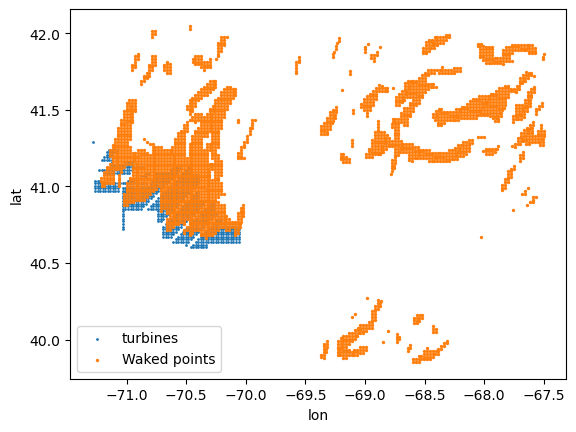

In [10]:
# plot the identified waked points
plt.scatter(la_turbines.longitude, la_turbines.latitude, s=1, label='turbines')
plt.scatter(points_filt1[:, 0], points_filt1[:, 1], s=2, label='Waked points')
plt.xlabel('lon')
plt.ylabel('lat')
plt.legend()

### Identify points in the wind farm wake using DBSCAN
- Compare to other clustering methods: https://scikit-learn.org/stable/modules/clustering.html
- DBSCAN and OPTICS explanation: https://www.atlantbh.com/clustering-algorithms-dbscan-vs-optics/
- example inspired by: https://towardsdatascience.com/outlier-detection-python-cd22e6a12098
- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
- Density-Based Spatial Clustering of Applications with Noise. Finds core samples of high density and expands clusters from them. Good for data which contains clusters of similar density
- eps is the maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster
- min_samples is the number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

In [11]:
# First we make a dataframe
df = pd.DataFrame()
df['lon'] = points_filt1[:, 0]
df['lat'] = points_filt1[:, 1]

# then we use the DBSCAN algorithm to cluster points together, pick the biggest clump for the wake
model = DBSCAN(eps=0.1, min_samples=30).fit(df.values)
df['labels'] = model.labels_ # each point is assigned a label

The label assigned to each point is represented with color

Text(0, 0.5, 'lat')

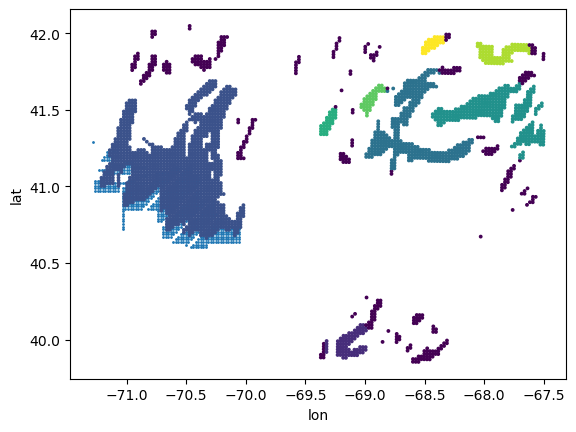

In [12]:
plt.scatter(la_turbines.longitude, la_turbines.latitude, s=1)
plt.scatter(df.lon, df.lat, c=df.labels, s=3)
plt.xlabel('lon')
plt.ylabel('lat')

### Select the best label, then subset the dataframe and create a list of points
- first subset to non-noise labels and labels with at least 5% in the wind farm
- then choose the label with the most points

In [13]:
# label = select_label(df)

In [14]:
labels = df.labels.unique(); labels

array([-1,  0,  1,  2,  3,  4,  5,  6,  7])

In [15]:
labels_nonoise = labels[labels>-1]

In [16]:
pcts = []
for l in labels_nonoise:
    pct = get_pct2(df[df.labels==l])
    pcts.append(pct)
    print(l, pct)

0 0.0
1 40.99236641221374
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0


In [17]:
labels_inwf = labels_nonoise[np.array(pcts)>5] ; labels_inwf

array([1])

In [18]:
# choose label with most points
num_points = []
for l in labels_inwf:
    num_points.append(df.labels.value_counts()[l])

In [19]:
label = labels_inwf[np.array(num_points).argmax()]

Text(0.5, 1.0, 'label=1')

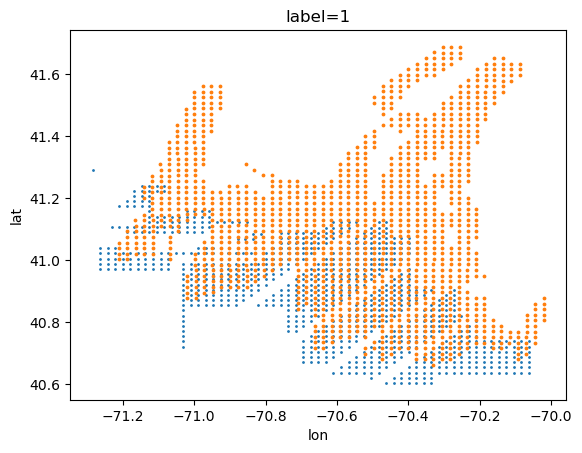

In [21]:
plt.scatter(la_turbines.longitude, la_turbines.latitude, s=1)
plt.scatter(df[df.labels==label].lon, df[df.labels==label].lat, s=3)
plt.xlabel('lon')
plt.ylabel('lat')
plt.title(f"label={label}")

In [22]:
df_filt = df[df.labels==label] # filter the dataframe for points in the wake
points_filt = np.array(list(zip(df_filt.lon, df_filt.lat))) # put the points in a form suitable for concave_hull algorithm

In [23]:
len(points_filt)

1310

In [24]:
len(points_filt)/len(points_filt1)

0.4992378048780488

### Draw a concave hull around the selected points

In [25]:
# Now apply the concave_hull algorithm to find a reasonable border around these points
idxes = concave_hull_indexes(points_filt, length_threshold=thresh)
hull_lon = concave_hull(points_filt, length_threshold=thresh)[:, 0]
hull_lat = concave_hull(points_filt, length_threshold=thresh)[:, 1]

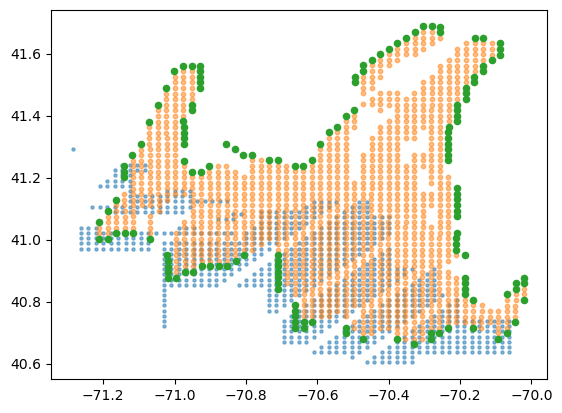

In [26]:
plt.scatter(la_turbines.longitude, la_turbines.latitude, s=5, alpha=0.5)
plt.scatter(points_filt[:, 0], points_filt[:, 1], s=10, alpha=0.5)
plt.scatter(hull_lon, hull_lat, s=20)

### Find the area of the wake

In [27]:
x, y = utm_proj(hull_lon, hull_lat) # convert to cartesian coordinates
    
# make a polygon and find the area
pgon = Polygon(zip(x, y))
area = pgon.area / 1000**2 # find the area, then convert from m^2 to km^2

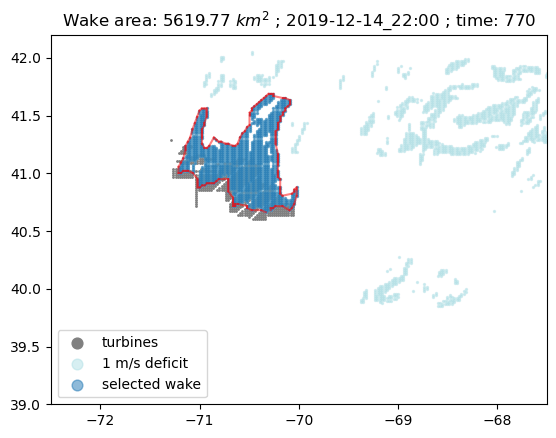

In [29]:
plt.scatter(la_turbines.longitude, la_turbines.latitude, s=1, color='grey', label='turbines')
plt.scatter(points_filt1[:, 0], points_filt1[:, 1], s=2, alpha=0.5, color='powderblue', label='1 m/s deficit')
plt.scatter(points_filt[:, 0], points_filt[:, 1], s=2, alpha=0.5, color='tab:blue', label='selected wake')
for f, t in zip(idxes[:-1], idxes[1:]): 
    seg = points_filt[[f, t]]
    plt.plot(seg[:, 0], seg[:, 1], "r-", alpha=0.5)

plt.xlim(-72.5, -67.5)
plt.ylim(39, 42.2)
plt.title(f'Wake area: {area:.2f} $km^{2}$ ; {nwf_files_stable[time][72:-3]} ; time: {time}')
lgnd = plt.legend()

lgnd.legend_handles[0]._sizes = [60]
lgnd.legend_handles[1]._sizes = [60]
lgnd.legend_handles[2]._sizes = [60]

### Find the longest distance from ONEcent to one of the concave hull indices

In [30]:
dist = wake_distance(list(zip(hull_lon, hull_lat))); dist

69.46987625645033

### Combine into a nice function :)

In [31]:
def plot_concave_hull(time, thresh=0.1, eps=0.1):
    # read in data
    nwf_ds = xr.open_dataset(nwf_files_stable[time])
    la_ds = xr.open_dataset(la_files_stable[time])
    print(time, nwf_files_stable[time])

    #calculate hub height wind speed
    nwf_wspd = calc_windspeed(nwf_ds).isel(bottom_top=11, Time=0)
    la_wspd = calc_windspeed(la_ds).isel(bottom_top=11, Time=0)

    # calculate the wind speed difference
    wspd_diff = la_wspd - nwf_wspd
    
    # nan all values not in the region of interest
    ext_bool = ((nwf_ds.XLAT.isel(Time=0)>39) & 
                (nwf_ds.XLAT.isel(Time=0)<42.3) & 
                (nwf_ds.XLONG.isel(Time=0)>-72.5) & 
                (nwf_ds.XLONG.isel(Time=0)<-67.5))

    # only look at region of interest and with a wspd deficit of at least 1 m/s
    trimmed_diff = wspd_diff.where(ext_bool)
    twaked_diff = trimmed_diff.where(trimmed_diff<-1)

    # mask latitude and longitude grids based on the wind speed deficit array
    lats_filt = nwf_ds.XLAT.isel(Time=0).where(twaked_diff.fillna(False), np.nan)
    lons_filt = nwf_ds.XLONG.isel(Time=0).where(twaked_diff.fillna(False), np.nan)

    # unravel 2D lat/lon grids and put in (lon, lat) form, then remove all points containing nan
    points = list(zip(lons_filt.values.ravel(), lats_filt.values.ravel()))
    points_filt1 = np.array([t for t in points if not any(np.isnan(x) for x in t)])
    
    # First we make a dataframe
    df = pd.DataFrame()
    df['lon'] = points_filt1[:, 0]
    df['lat'] = points_filt1[:, 1]

    # then we use the DBSCAN algorithm to cluster points together, pick the biggest clump for the wake
    model = DBSCAN(eps=eps, min_samples=30).fit(df.values)
    df['labels'] = model.labels_ # each point is assigned a label
    
    label = select_label(df)
    if label==None:
        return None
    
    df_filt = df[df.labels==label] # filter the dataframe for points in the wake
    points_filt = np.array(list(zip(df_filt.lon, df_filt.lat))) # put the points in a form suitable for concave_hull algorithm
    print(len(points_filt)/len(points_filt1))
    
    # Now apply the concave_hull algorithm to find a reasonable border around these points
    idxes = concave_hull_indexes(points_filt, length_threshold=thresh)
    hull_lon = concave_hull(points_filt, length_threshold=thresh)[:, 0]
    hull_lat = concave_hull(points_filt, length_threshold=thresh)[:, 1]
    
    x, y = utm_proj(hull_lon, hull_lat) # convert to cartesian coordinates
    
    # make a polygon and find the area
    pgon = Polygon(zip(x, y))
    area = pgon.area / 1000**2 # find the area, then convert from m^2 to km^2
    
    dist = wake_distance(list(zip(hull_lon, hull_lat))); dist
    
    plt.scatter(la_turbines.longitude, la_turbines.latitude, s=1, color='grey', label='turbines')
    plt.scatter(points_filt1[:, 0], points_filt1[:, 1], s=2, alpha=0.5, color='powderblue', label='1 m/s deficit')
    plt.scatter(points_filt[:, 0], points_filt[:, 1], s=2, alpha=0.5, color='tab:blue', label='selected wake')
    for f, t in zip(idxes[:-1], idxes[1:]): 
        seg = points_filt[[f, t]]
        plt.plot(seg[:, 0], seg[:, 1], "r-", alpha=0.5)

    plt.xlim(-72.5, -67.5)
    plt.ylim(39, 42.2)
    plt.title(f'Wake area: {area:.0f} $km^{2}$ ; dist: {dist:.1f}km ; {nwf_files_stable[time][72:-3]} ; time: {time}')
    lgnd = plt.legend()

    lgnd.legend_handles[0]._sizes = [60]
    lgnd.legend_handles[1]._sizes = [60]
    lgnd.legend_handles[2]._sizes = [60]

770 /pl/active/JKL_REAL/N_Atl/reruns_Beiter/wrfouts/nwf/2019//12/wrfout_d02_2019-12-14_22:00:00
0.4992378048780488


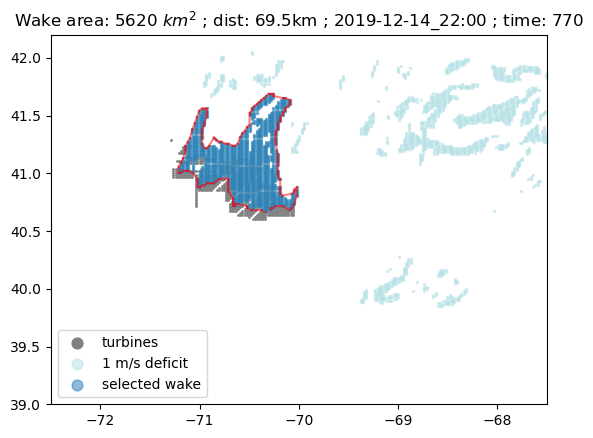

In [32]:
plot_concave_hull(770)

468 /pl/active/JKL_REAL/N_Atl/reruns_Beiter/wrfouts/nwf/2019//10/wrfout_d02_2019-10-24_20:00:00
0.14977973568281938


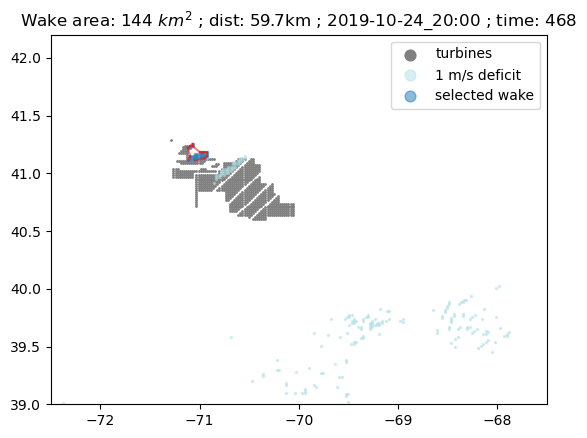

In [33]:
plot_concave_hull(468)

22 /pl/active/JKL_REAL/N_Atl/reruns_Beiter/wrfouts/nwf/2019//09/wrfout_d02_2019-09-03_04:00:00
0.16384306732055284


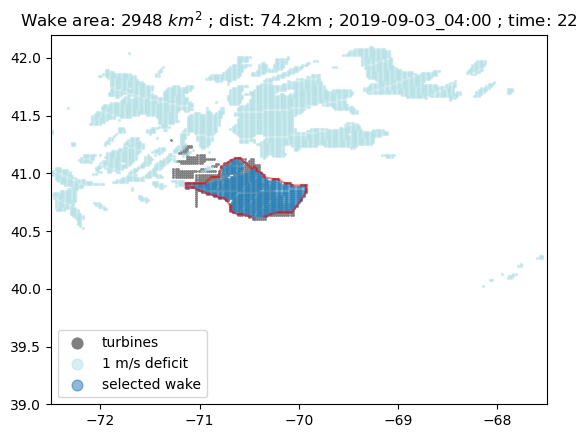

In [34]:
plot_concave_hull(22)

25 /pl/active/JKL_REAL/N_Atl/reruns_Beiter/wrfouts/nwf/2019//09/wrfout_d02_2019-09-04_12:00:00
0.2279555845852384


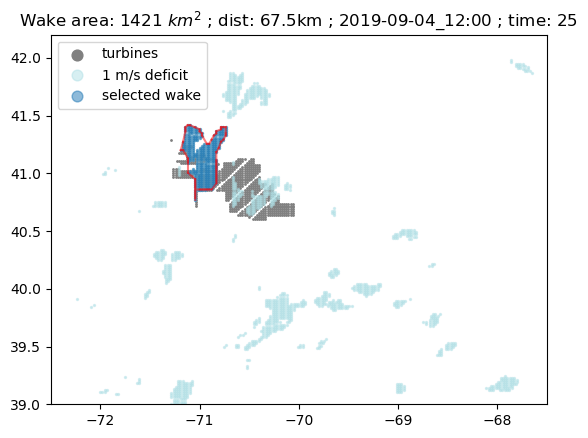

In [35]:
plot_concave_hull(25)

512 /pl/active/JKL_REAL/N_Atl/reruns_Beiter/wrfouts/nwf/2019//10/wrfout_d02_2019-10-28_00:00:00
0.1194074074074074


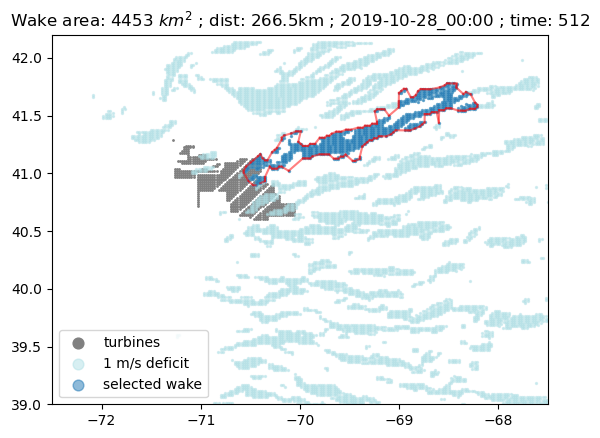

In [36]:
plot_concave_hull(512)

513 /pl/active/JKL_REAL/N_Atl/reruns_Beiter/wrfouts/nwf/2019//10/wrfout_d02_2019-10-28_01:00:00
0.0838006230529595


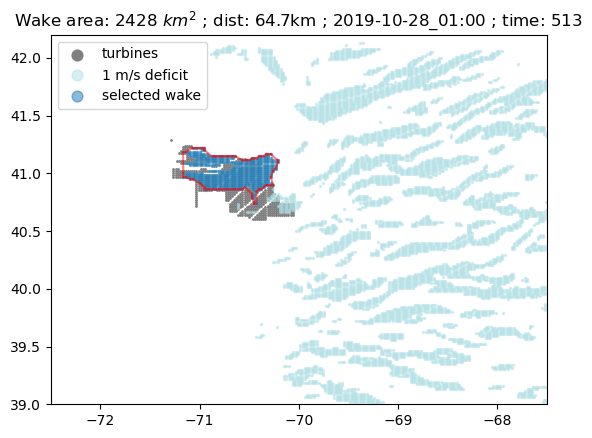

In [37]:
plot_concave_hull(513)

38 /pl/active/JKL_REAL/N_Atl/reruns_Beiter/wrfouts/nwf/2019//09/wrfout_d02_2019-09-05_01:00:00


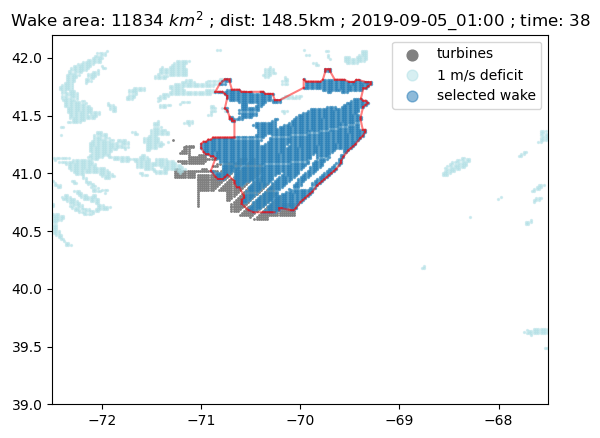

In [10]:
plot_concave_hull(38)

In [37]:
list(nwf_files_stable).index('/pl/active/JKL_REAL/N_Atl/reruns_Beiter/wrfouts/nwf/2019//10/wrfout_d02_2019-10-28_01:00:00')

513